In [1]:
# pip install numpy pandas librosa soundfile matplotlib seaborn scikit-learn tensorflow

In [1]:
import os, re, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2025-12-04 07:43:22.916088: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 07:43:23.013630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 07:43:24.010717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

# ====== 修改为你的 AudioWAV 路径 ======
AUDIO_DIR = "../AudioWAV"
AUDIO_DIR = Path(AUDIO_DIR)
assert AUDIO_DIR.exists(), f"路径不存在：{AUDIO_DIR}"

# 固定随机种子，结果更可复现
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [3]:
# CREMA-D 文件名格式： <speaker>_<sentence>_<emotion>_<intensity>.wav
# 例：1001_DFA_ANG_XX.wav
pat = re.compile(r"(?P<spk>\d{4})_(?P<sent>[A-Z]{3})_(?P<emo>[A-Z]{3})_(?P<inten>[A-Z]{2})\.wav$", re.I)

def parse_filename(p: Path):
    m = pat.search(p.name)
    if not m:
        return None
    gd = m.groupdict()
    return {
        "path": p,
        "speaker": int(gd["spk"]),
        "sentence": gd["sent"].upper(),
        "emotion": gd["emo"].upper(),
        "intensity": gd["inten"].upper(),
    }

files = sorted(AUDIO_DIR.glob("*.wav"))
rows = [parse_filename(p) for p in files]
meta = pd.DataFrame([r for r in rows if r is not None])

# 情绪与强度的映射/可读名
EMO_MAP = {"ANG":"Anger", "DIS":"Disgust", "FEA":"Fear", "HAP":"Happy", "NEU":"Neutral", "SAD":"Sad"}
INTEN_ORDER = ["LO","MD","HI","XX"]  # XX=未知
meta["emotion_name"] = meta["emotion"].map(EMO_MAP)
meta["intensity"] = pd.Categorical(meta["intensity"], categories=INTEN_ORDER, ordered=True)

meta.head()


,path,speaker,sentence,emotion,intensity,emotion_name
0,AudioWAV/1001_DFA_ANG_XX.wav,1001,DFA,ANG,XX,Anger
1,AudioWAV/1001_DFA_DIS_XX.wav,1001,DFA,DIS,XX,Disgust
2,AudioWAV/1001_DFA_FEA_XX.wav,1001,DFA,FEA,XX,Fear
3,AudioWAV/1001_DFA_HAP_XX.wav,1001,DFA,HAP,XX,Happy
4,AudioWAV/1001_DFA_NEU_XX.wav,1001,DFA,NEU,XX,Neutral


In [4]:
# 查看强度列的数值统计
print(meta["intensity"].value_counts())

intensity
XX    6077
LO     455
MD     455
HI     455
Name: count, dtype: int64


In [4]:
# 2.1 基本计数
print("样本数：", len(meta))
print("说话人数：", meta['speaker'].nunique())
print("句子种类：", meta['sentence'].nunique())
print(meta["emotion"].value_counts().rename(index=EMO_MAP))

# 2.2 每个样本的时长（使用 soundfile 读取头信息，速度快）
def fast_duration(path: Path):
    info = sf.info(str(path))
    return info.frames / info.samplerate

meta["duration_sec"] = meta["path"].apply(fast_duration)
meta.describe(include="all")


样本数： 7442
说话人数： 91
句子种类： 12
emotion
Anger      1271
Disgust    1271
Fear       1271
Happy      1271
Sad        1271
Neutral    1087
Name: count, dtype: int64


,path,speaker,sentence,emotion,intensity,emotion_name,duration_sec
count,7442,7442.000000,7442,7442,7442,7442,7442.000000
unique,7442,NaN,12,6,4,6,NaN
top,AudioWAV/1001_DFA_ANG_XX.wav,NaN,IEO,ANG,XX,Anger,NaN
freq,1,NaN,1456,1271,6077,1271,NaN
mean,NaN,1046.084117,NaN,NaN,NaN,NaN,2.542884
std,NaN,26.243152,NaN,NaN,NaN,NaN,0.505979
min,NaN,1001.000000,NaN,NaN,NaN,NaN,1.267937
25%,NaN,1023.000000,NaN,NaN,NaN,NaN,2.202187
50%,NaN,1046.000000,NaN,NaN,NaN,NaN,2.502500
75%,NaN,1069.000000,NaN,NaN,NaN,NaN,2.836187


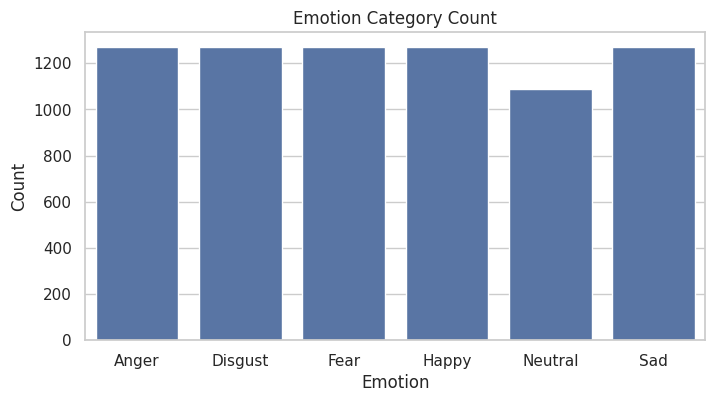

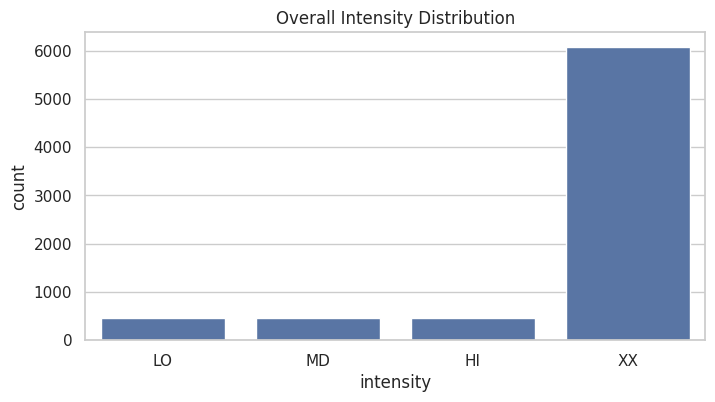

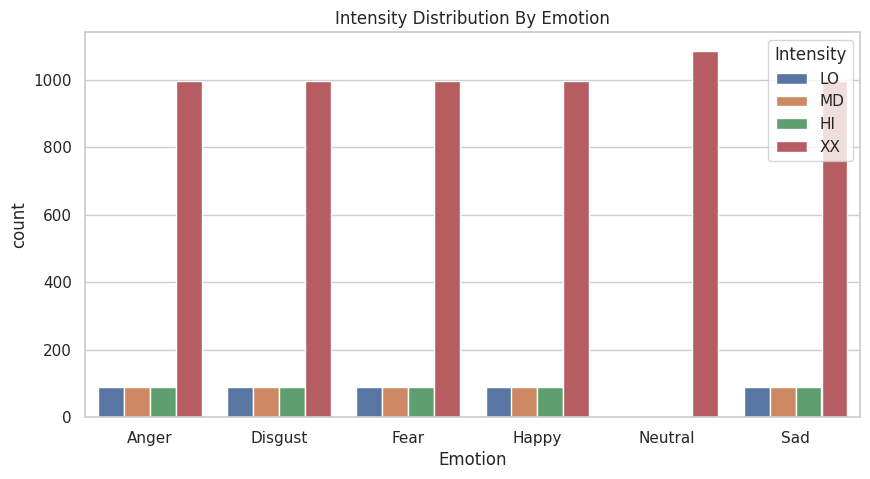

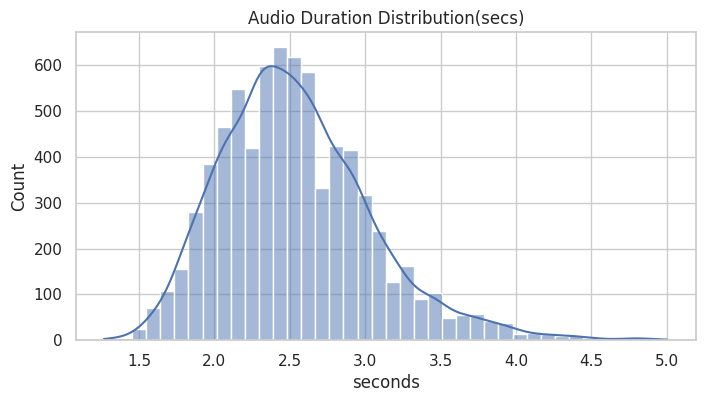

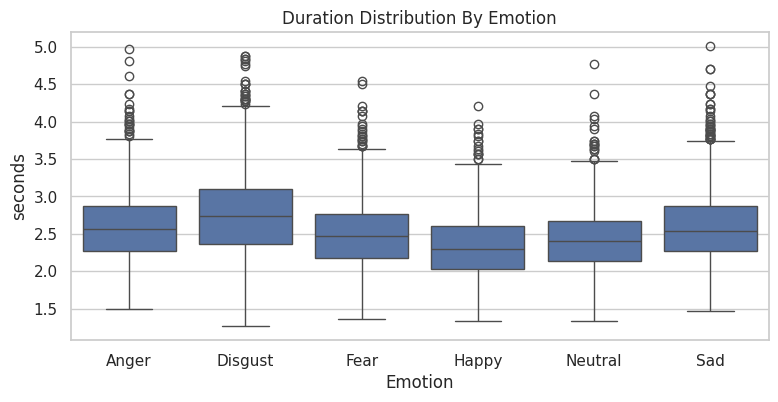

In [5]:
# 2.3 类别分布柱状图

plt.figure(figsize=(8,4))
sns.countplot(data=meta, x="emotion_name", order=[EMO_MAP[k] for k in ["ANG","DIS","FEA","HAP","NEU","SAD"]])
plt.title("Emotion Category Count")
plt.xlabel("Emotion"); plt.ylabel("Count"); plt.xticks(rotation=0)
plt.show()

# 2.4 强度分布（总体 & 不同情绪）
plt.figure(figsize=(8,4))
sns.countplot(data=meta, x="intensity")
plt.title("Overall Intensity Distribution"); plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=meta, x="emotion_name", hue="intensity",
              order=[EMO_MAP[k] for k in ["ANG","DIS","FEA","HAP","NEU","SAD"]])
plt.title("Intensity Distribution By Emotion"); plt.xlabel("Emotion"); plt.legend(title="Intensity")
plt.show()

# 2.5 时长分布
plt.figure(figsize=(8,4))
sns.histplot(meta["duration_sec"], bins=40, kde=True)
plt.title("Audio Duration Distribution(secs)"); plt.xlabel("seconds"); plt.show()

plt.figure(figsize=(9,4))
sns.boxplot(data=meta, x="emotion_name", y="duration_sec",
            order=[EMO_MAP[k] for k in ["ANG","DIS","FEA","HAP","NEU","SAD"]])
plt.title("Duration Distribution By Emotion"); plt.xlabel("Emotion"); plt.ylabel("seconds")
plt.show()


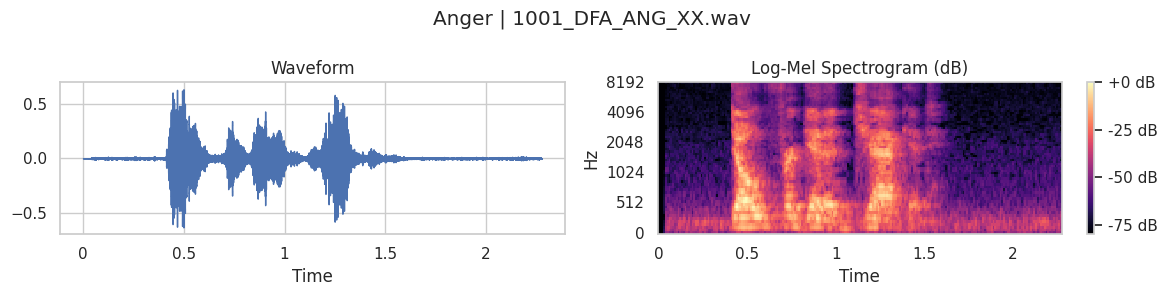

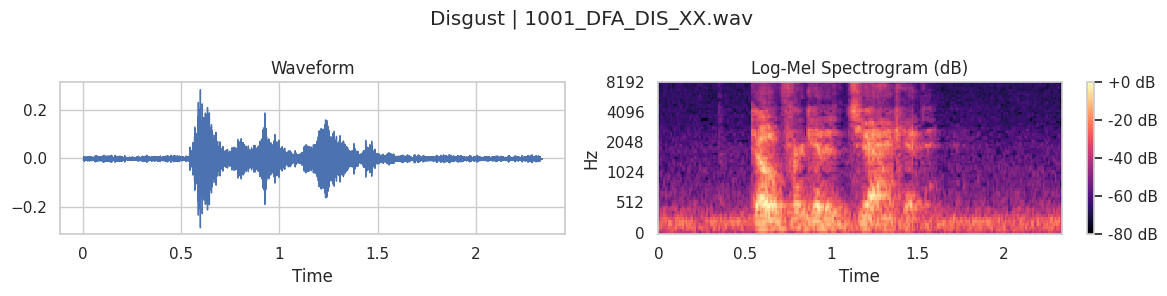

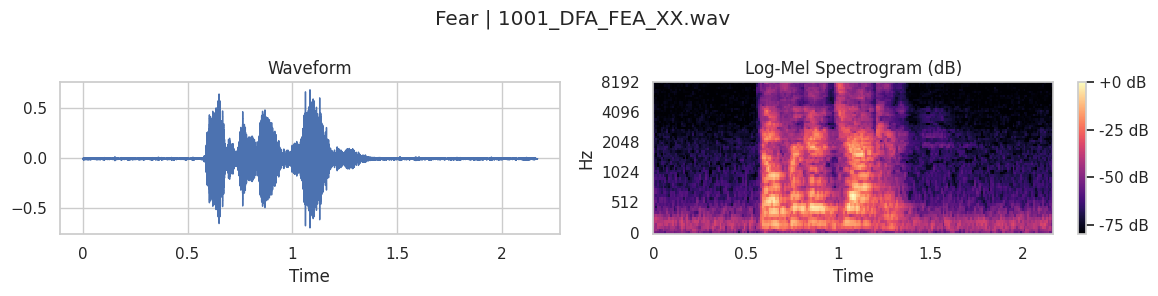

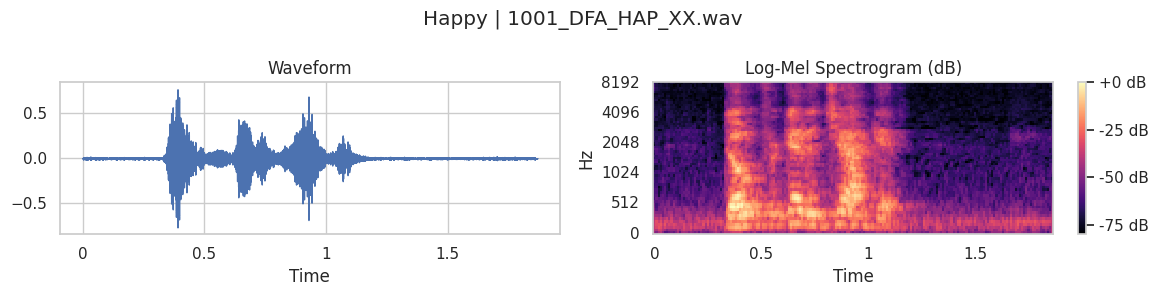

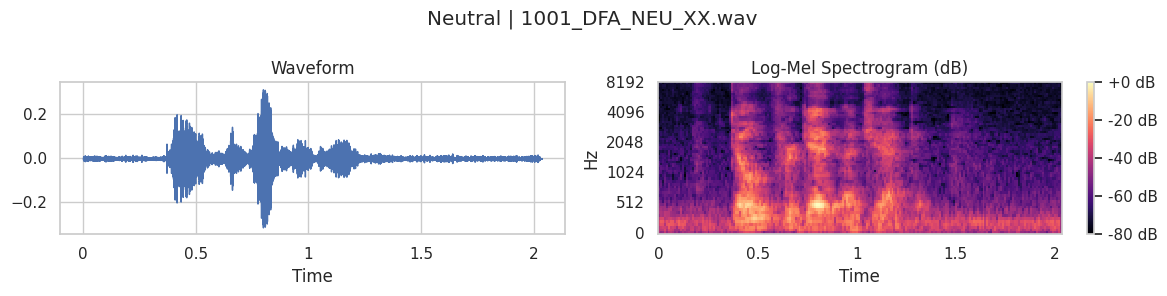

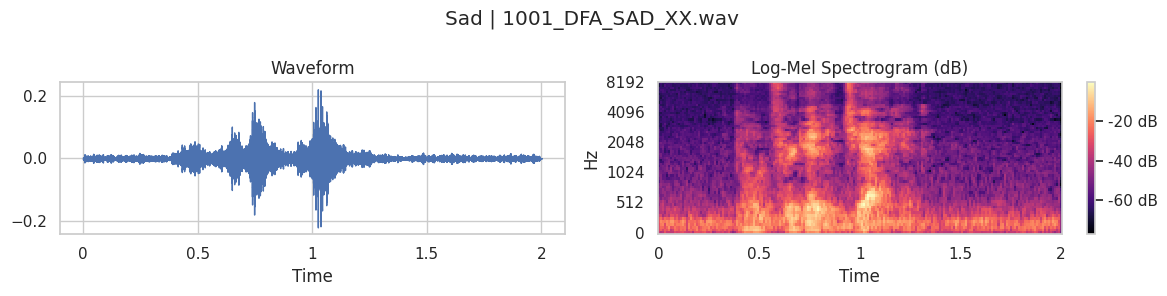

In [6]:
SR = 16000   # 统一重采样到 16 kHz，便于后续特征对齐
N_MELS = 64
FFT = 1024
HOP = 160     # 10ms hop at 16kHz
WIN = 400     # 25ms window

def plot_wave_and_mel(path: Path, title=None):
    # 强制所有文本使用 Arial，不被 Jupyter/VSCode 主题替换
    with plt.rc_context({
        'font.family': 'DejaVu Sans',
        'mathtext.default': 'regular',   # 禁用 mathtext 的特殊渲染
        'text.usetex': False             # 强制不使用 LaTeX
    }):
        y, _ = librosa.load(path, sr=SR, mono=True)
        fig, axes = plt.subplots(1,2, figsize=(12,3))

        # 波形
        librosa.display.waveshow(y, sr=SR, ax=axes[0])
        axes[0].set_title("Waveform")

        # 梅尔谱
        S = librosa.feature.melspectrogram(
            y=y, sr=SR, n_fft=FFT, hop_length=HOP,
            win_length=WIN, n_mels=N_MELS, power=2.0
        )
        S_db = librosa.power_to_db(S, ref=np.max)

        img = librosa.display.specshow(
            S_db, sr=SR, hop_length=HOP,
            x_axis='time', y_axis='mel', ax=axes[1]
        )
        axes[1].set_title("Log-Mel Spectrogram (dB)")
        fig.colorbar(img, ax=axes[1], format="%+2.f dB")

        # suptitle 不会再出现空格拉伸
        plt.suptitle(title or path.name, fontfamily="DejaVu Sans")

        plt.tight_layout()
        plt.show()




# 每个情绪各挑一条看看
examples = []
for emo in ["ANG","DIS","FEA","HAP","NEU","SAD"]:
    p = meta.loc[meta["emotion"]==emo, "path"].iloc[0]
    examples.append(p)
    plot_wave_and_mel(p, title=f"{EMO_MAP[emo]} | {p.name}")


In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
def extract_handcrafted_features(path: Path, sr=SR):
    y, _ = librosa.load(path, sr=sr, mono=True)
    # 能量归一：librosa 已返回 -1..1 浮点；这里再做一次简单归一（可选）
    y = librosa.util.normalize(y)

    feats = {}

    # 1) MFCC（取 20 维）+ 一阶/二阶差分的均值/方差
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=FFT, hop_length=HOP)
    for statname, statfunc in [("mean", np.mean), ("std", np.std)]:
        vals = statfunc(mfcc, axis=1)
        for i, v in enumerate(vals, start=1):
            feats[f"mfcc{i}_{statname}"] = float(v)

    # 2) 频谱质心/带宽/滚降（rolloff）/谱平坦度 + 均值/标准差
    specs = {
        "centroid": librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FFT, hop_length=HOP),
        "bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FFT, hop_length=HOP),
        "rolloff": librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=FFT, hop_length=HOP),
        "flatness": librosa.feature.spectral_flatness(y=y, n_fft=FFT, hop_length=HOP)
    }
    for k, arr in specs.items():
        feats[f"{k}_mean"] = float(np.mean(arr))
        feats[f"{k}_std"]  = float(np.std(arr))

    # 3) 零交叉率 & RMS 能量
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP)
    rms = librosa.feature.rms(y=y, frame_length=WIN, hop_length=HOP)
    feats["zcr_mean"] = float(np.mean(zcr)); feats["zcr_std"] = float(np.std(zcr))
    feats["rms_mean"] = float(np.mean(rms)); feats["rms_std"] = float(np.std(rms))

    # 4) Chroma（12 维）均值
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=FFT, hop_length=HOP)
    for i, v in enumerate(np.mean(chroma, axis=1), start=1):
        feats[f"chroma{i}_mean"] = float(v)

    # 5) 基频 F0（YIN）中位数 + 发声占比
    try:
        f0 = librosa.yin(y, fmin=50, fmax=500, sr=sr, frame_length=WIN, hop_length=HOP)
        voiced = ~np.isnan(f0)
        feats["f0_median"] = float(np.nanmedian(f0))
        feats["voiced_ratio"] = float(np.mean(voiced))
    except Exception:
        feats["f0_median"] = 0.0
        feats["voiced_ratio"] = 0.0

    # 6) 估计节拍(tempo)（不一定有效，但可作为额外特征）
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        feats["tempo"] = float(tempo)
    except Exception:
        feats["tempo"] = 0.0

    return feats

# 批量提取
feature_rows = []
for r in meta.itertuples():
    feats = extract_handcrafted_features(r.path)
    feats.update({
        "emotion": r.emotion,
        "speaker": r.speaker,
        "intensity": r.intensity,
        "duration_sec": r.duration_sec,
        "fname": r.path.name
    })
    feature_rows.append(feats)

feat_df = pd.DataFrame(feature_rows).set_index("fname")
print("特征维度：", feat_df.shape)
feat_df.head()


特征维度： (7442, 71)


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,chroma10_mean,chroma11_mean,chroma12_mean,f0_median,voiced_ratio,tempo,emotion,speaker,intensity,duration_sec
fname,,,,,,,,,,,,,,,,,,,,,
1001_DFA_ANG_XX.wav,-341.173309,93.019478,11.351363,24.081890,8.176378,-5.630590,-11.947346,-9.056320,-3.718214,-13.239969,...,0.518667,0.634780,0.612818,120.102777,1.0,133.928571,ANG,1001,XX,2.275562
1001_DFA_DIS_XX.wav,-302.324768,96.306114,12.832700,31.296909,17.008780,-6.372927,-6.565848,-4.510122,-5.338439,-10.021337,...,0.618732,0.663759,0.545201,95.127862,1.0,98.684211,DIS,1001,XX,2.335688
1001_DFA_FEA_XX.wav,-364.025848,92.344849,11.941285,23.627533,12.349589,-7.241534,-8.635369,-4.423936,-5.104712,-13.808980,...,0.623476,0.617930,0.431532,112.690304,1.0,133.928571,FEA,1001,XX,2.168813
1001_DFA_HAP_XX.wav,-357.791534,93.023003,6.937078,28.259138,11.377559,-11.540567,-9.881716,-6.692438,-7.958680,-17.249489,...,0.533127,0.637394,0.570113,153.689342,1.0,117.187500,HAP,1001,XX,1.868500
1001_DFA_NEU_XX.wav,-302.423431,101.298561,11.856271,29.674608,12.435848,-3.424319,-7.737626,-8.624991,-6.281280,-11.872980,...,0.643194,0.627003,0.482948,105.527070,1.0,156.250000,NEU,1001,XX,2.035375


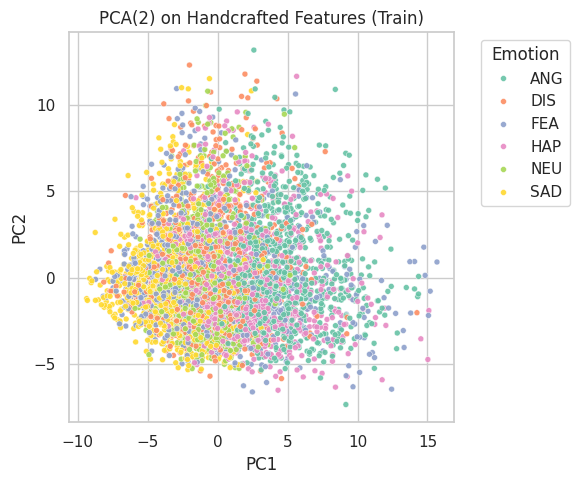

In [10]:
# 4.1 字段准备：标签编码 + 说话人分组划分（避免同一说话人泄漏到测试集）
le_emo = LabelEncoder()
y_all = le_emo.fit_transform(feat_df["emotion"].values)  # 0..5
groups = meta.set_index("path").loc[feat_df.index.map(lambda n: AUDIO_DIR/n), "speaker"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(feat_df, y_all, groups=groups))

X_all = feat_df.drop(columns=["emotion","speaker","intensity","duration_sec"]).astype(np.float32).values
X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# 4.2 归一化（仅用训练集拟合，避免数据泄漏）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# 4.3 PCA 可视化（仅用于理解数据分布）
pca_2 = PCA(n_components=2, random_state=SEED)
P_train = pca_2.fit_transform(X_train)
plt.figure(figsize=(6,5))
sns.scatterplot(x=P_train[:,0], y=P_train[:,1], hue=le_emo.inverse_transform(y_train),
                palette="Set2", s=18, alpha=0.9)
plt.title("PCA(2) on Handcrafted Features (Train)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(title="Emotion", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()


In [12]:
import numpy as np
import pandas as pd
import librosa
from pathlib import Path

# -------------- v2: 手工特征提取函数 -------------- #
def extract_handcrafted_features_v2(path: Path, sr=SR):
    y, _ = librosa.load(path, sr=sr, mono=True)
    # 能量归一
    y = librosa.util.normalize(y)

    feats = {}

    # ===== 1) MFCC + delta + delta-delta（CMVN 后统计） =====
    n_mfcc = 20
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=n_mfcc,
        n_fft=FFT, hop_length=HOP
    )
    # CMVN: 在时间轴做均值方差归一
    mfcc = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (
        mfcc.std(axis=1, keepdims=True) + 1e-8
    )

    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)

    def add_stats(prefix, arr):
        for statname, statfunc in [("mean", np.mean), ("std", np.std)]:
            vals = statfunc(arr, axis=1)
            for i, v in enumerate(vals, start=1):
                feats[f"{prefix}{i}_{statname}"] = float(v)

    add_stats("mfcc", mfcc)
    add_stats("mfcc_d1_", delta1)
    add_stats("mfcc_d2_", delta2)

    # ===== 2) 频谱特征：质心/带宽/滚降/谱平坦度 =====
    specs = {
        "centroid": librosa.feature.spectral_centroid(
            y=y, sr=sr, n_fft=FFT, hop_length=HOP
        ),
        "bandwidth": librosa.feature.spectral_bandwidth(
            y=y, sr=sr, n_fft=FFT, hop_length=HOP
        ),
        "rolloff": librosa.feature.spectral_rolloff(
            y=y, sr=sr, n_fft=FFT, hop_length=HOP
        ),
        "flatness": librosa.feature.spectral_flatness(
            y=y, n_fft=FFT, hop_length=HOP
        ),
    }
    for k, arr in specs.items():
        vals = arr
        feats[f"{k}_mean"] = float(np.mean(vals))
        feats[f"{k}_std"]  = float(np.std(vals))

    # ===== 3) ZCR & RMS：全局 + 分段动态 =====
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP)
    rms = librosa.feature.rms(y=y, frame_length=WIN, hop_length=HOP)

    feats["zcr_mean"] = float(np.mean(zcr))
    feats["zcr_std"]  = float(np.std(zcr))
    feats["rms_mean"] = float(np.mean(rms))
    feats["rms_std"]  = float(np.std(rms))

    def segment_means(arr, n_seg=3):
        T = arr.shape[-1]
        seg_len = max(1, T // n_seg)
        means = []
        for s in range(n_seg):
            start = s * seg_len
            end = T if s == n_seg - 1 else (s + 1) * seg_len
            means.append(float(np.mean(arr[..., start:end])))
        return means

    for i, m in enumerate(segment_means(rms), start=1):
        feats[f"rms_seg{i}_mean"] = m
    for i, m in enumerate(segment_means(zcr), start=1):
        feats[f"zcr_seg{i}_mean"] = m

    # ===== 4) Chroma 均值 =====
    chroma = librosa.feature.chroma_stft(
        y=y, sr=sr, n_fft=FFT, hop_length=HOP
    )
    for i, v in enumerate(np.mean(chroma, axis=1), start=1):
        feats[f"chroma{i}_mean"] = float(v)

    # ===== 5) 基频 F0 统计 + 发声占比 =====
    try:
        f0 = librosa.yin(
            y, fmin=50, fmax=500, sr=sr,
            frame_length=WIN, hop_length=HOP
        )
        voiced = ~np.isnan(f0)
        if np.any(voiced):
            f0_voiced = f0[voiced]
            feats["f0_median"] = float(np.median(f0_voiced))
            feats["f0_mean"]   = float(np.mean(f0_voiced))
            feats["f0_std"]    = float(np.std(f0_voiced))
            feats["f0_min"]    = float(np.min(f0_voiced))
            feats["f0_max"]    = float(np.max(f0_voiced))
            feats["f0_range"]  = float(np.max(f0_voiced) - np.min(f0_voiced))
            feats["f0_p10"]    = float(np.percentile(f0_voiced, 10))
            feats["f0_p90"]    = float(np.percentile(f0_voiced, 90))
            feats["voiced_ratio"] = float(np.mean(voiced))
        else:
            raise RuntimeError("no voiced frames")
    except Exception:
        for k in [
            "f0_median","f0_mean","f0_std","f0_min","f0_max",
            "f0_range","f0_p10","f0_p90","voiced_ratio"
        ]:
            feats[k] = 0.0

    # ===== 6) 估计节拍 Tempo（可弱特征） =====
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        feats["tempo"] = float(tempo)
    except Exception:
        feats["tempo"] = 0.0

    return feats


# -------------- 批量提取，构建 feat_df -------------- #
feature_rows = []
for r in meta.itertuples():
    feats = extract_handcrafted_features_v2(r.path)
    feats.update({
        "emotion":      r.emotion,
        "speaker":      r.speaker,
        "intensity":    r.intensity,
        "duration_sec": r.duration_sec,
        "fname":        r.path.name,
    })
    feature_rows.append(feats)

feat_df = pd.DataFrame(feature_rows).set_index("fname")
print("Feature shape:", feat_df.shape)
display(feat_df.head())


Feature shape: (7442, 164)


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,f0_max,f0_range,f0_p10,f0_p90,voiced_ratio,tempo,emotion,speaker,intensity,duration_sec
fname,,,,,,,,,,,,,,,,,,,,,
1001_DFA_ANG_XX.wav,-7.529007e-08,-8.574703e-08,-5.855895e-08,8.365564e-09,-1.673113e-08,3.555365e-08,-1.882252e-08,0.000000e+00,-5.019339e-08,1.547629e-07,...,500.00000,450.00000,57.014109,237.597115,1.0,133.928571,ANG,1001,XX,2.275562
1001_DFA_DIS_XX.wav,1.793234e-07,2.404564e-07,5.934992e-08,-1.467191e-07,-9.679387e-08,-1.426436e-08,-1.630213e-08,-3.260425e-08,0.000000e+00,5.705744e-08,...,500.00000,450.00000,54.094008,228.732050,1.0,98.684211,DIS,1001,XX,2.335688
1001_DFA_FEA_XX.wav,1.494236e-07,-2.021614e-07,2.417147e-08,-2.636888e-08,1.757925e-08,1.977666e-08,-1.098703e-08,1.757925e-08,-6.152737e-08,3.515850e-08,...,445.10457,395.10457,55.900530,223.303411,1.0,133.928571,FEA,1001,XX,2.168813
1001_DFA_HAP_XX.wav,1.121970e-07,1.835950e-07,0.000000e+00,1.759453e-07,1.019973e-08,-6.629821e-08,-1.529959e-08,0.000000e+00,8.669767e-08,2.039945e-08,...,500.00000,450.00000,55.645889,230.031346,1.0,117.187500,HAP,1001,XX,1.868500
1001_DFA_NEU_XX.wav,1.308965e-07,9.349749e-09,1.869950e-08,0.000000e+00,-7.479799e-08,-2.571181e-08,9.349749e-09,0.000000e+00,-1.869950e-08,-5.609849e-08,...,500.00000,450.00000,54.401673,230.278121,1.0,156.250000,NEU,1001,XX,2.035375


In [13]:
# 3.x 特征后处理：压缩谱特征 + 裁剪 F0

# 1）对谱特征（Hz 级别的）做 log 压缩，避免几千 vs 0.x 的巨大量纲差
spec_cols = [
    "centroid_mean", "centroid_std",
    "bandwidth_mean", "bandwidth_std",
    "rolloff_mean",  "rolloff_std",
]

for col in spec_cols:
    if col in feat_df.columns:
        # 防止负数，先 clip 到 >=0 再 log1p
        feat_df[col] = np.log1p(feat_df[col].clip(lower=0.0))

# 2）对 F0 系列做合理裁剪，避免 500 这种上限堆积拉爆方差
f0_cols = [c for c in feat_df.columns if c.startswith("f0_")]
for col in f0_cols:
    # 语音里大多数说话人 F0 不会长期大于 400 Hz，这里做一个上限裁剪
    feat_df[col] = feat_df[col].clip(lower=0.0, upper=400.0)

# 3）节拍 tempo 也简单裁剪一下（防止少数极端值）
if "tempo" in feat_df.columns:
    feat_df["tempo"] = feat_df["tempo"].clip(lower=0.0, upper=250.0)


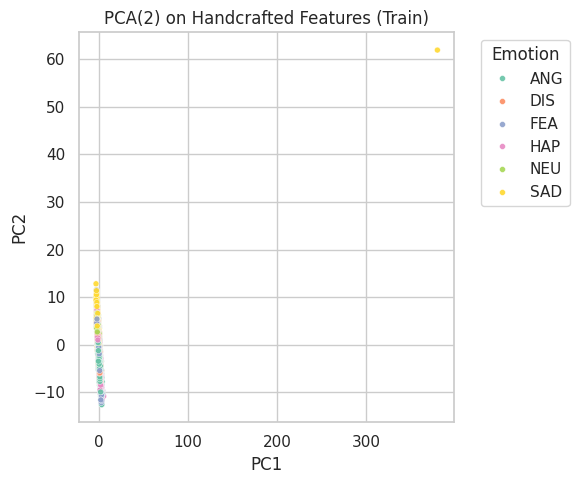

In [15]:
# 4.1 字段准备：标签编码 + 说话人分组划分（避免同一说话人泄漏到测试集）

le_emo = LabelEncoder()
y_all = le_emo.fit_transform(feat_df["emotion"].values)  # 0..5
groups = meta.set_index("path").loc[feat_df.index.map(lambda n: AUDIO_DIR/n), "speaker"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(feat_df, y_all, groups=groups))

X_all = feat_df.drop(columns=["emotion","speaker","intensity","duration_sec"]).astype(np.float32).values
X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# 4.2 归一化（仅用训练集拟合，避免数据泄漏）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# 4.3 PCA 可视化（仅用于理解数据分布）
pca_2 = PCA(n_components=2, random_state=SEED)
P_train = pca_2.fit_transform(X_train)

with plt.rc_context({
    'font.family': 'DejaVu Sans',
    'mathtext.default': 'regular',
    'text.usetex': False
}):
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=P_train[:,0], y=P_train[:,1],
        hue=le_emo.inverse_transform(y_train),
        palette="Set2", s=18, alpha=0.9
    )
    plt.title("PCA(2) on Handcrafted Features (Train)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Emotion", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()



In [16]:
# 找训练集中特征分布异常的列
df = pd.DataFrame(X_train_raw, columns=feat_df.drop(columns=[
    "emotion","speaker","intensity","duration_sec"
]).columns)

print(df.describe().T.sort_values("std", ascending=False).head(20))


                 count        mean        std         min         25%   
f0_range        5890.0  334.212952  74.241875    0.000000  265.040802  \
f0_p90          5890.0  238.870117  61.383739   89.977348  208.525646   
f0_max          5890.0  360.208191  54.846661  192.705429  315.058441   
f0_median       5890.0  134.412598  48.015610   65.959160  102.318451   
tempo           5890.0  133.565216  36.922298    0.000000  104.166664   
f0_mean         5890.0  141.812515  35.160805   73.232353  117.207903   
f0_std          5890.0   77.072113  23.563623    0.000000   62.179252   
f0_p10          5890.0   55.586555   5.303535   50.310814   53.943654   
f0_min          5890.0   50.065857   4.561610   50.000000   50.000000   
centroid_std    5890.0    6.281461   0.497010    0.000000    5.938884   
rolloff_std     5890.0    7.145993   0.260786    0.000000    6.975690   
bandwidth_std   5890.0    5.846782   0.221735    0.000000    5.715338   
centroid_mean   5890.0    7.250363   0.191826    0.

In [17]:
# 假设你已经有：feat_df, train_idx, P_train

numeric_cols = feat_df.drop(
    columns=["emotion", "speaker", "intensity", "duration_sec"]
).columns

# 计算每个点在 PCA 平面上的距离
dists = np.linalg.norm(P_train, axis=1)

# 取距离最大的前 k 个（通常 1~5 就够了）
k = 5
topk_idx = np.argsort(dists)[-k:]

print("Top PCA outliers (train indices):", topk_idx)

outlier_info = []
for idx in topk_idx:
    global_idx = train_idx[idx]          # 在 feat_df 中的行号
    fname = feat_df.iloc[global_idx].name
    outlier_info.append(fname)
    print(f"\n=== Outlier #{idx} ===")
    print("global_idx:", global_idx, "fname:", fname)


Top PCA outliers (train indices): [ 424  491 3355 5663 4799]

=== Outlier #424 ===
global_idx: 588 fname: 1008_IEO_HAP_HI.wav

=== Outlier #491 ===
global_idx: 655 fname: 1009_IEO_ANG_HI.wav

=== Outlier #3355 ===
global_idx: 4415 fname: 1055_IEO_ANG_HI.wav

=== Outlier #5663 ===
global_idx: 7133 fname: 1088_IEO_SAD_HI.wav

=== Outlier #4799 ===
global_idx: 6187 fname: 1076_MTI_SAD_XX.wav


In [18]:
for fname in outlier_info:
    print("\n==============================")
    print("File:", fname)
    row = feat_df.loc[fname, numeric_cols]

    # 转 float，不能转的变成 NaN，避免 sort 报错
    row_num = pd.to_numeric(row, errors="coerce")

    # 打印最大的 20 个数值特征
    print(row_num.sort_values(ascending=False).head(20))



File: 1008_IEO_HAP_HI.wav
f0_p90            400.000000
f0_range          400.000000
f0_max            400.000000
f0_mean           264.921304
f0_median         239.499909
f0_std            159.514645
tempo             156.250000
f0_p10             55.971281
f0_min             50.000000
rolloff_mean        8.249390
bandwidth_mean      7.522606
centroid_mean       7.497188
rolloff_std         6.673791
centroid_std        6.321787
bandwidth_std       5.508204
mfcc8_std           1.000000
mfcc20_std          1.000000
mfcc19_std          1.000000
mfcc18_std          1.000000
mfcc17_std          1.000000
Name: 1008_IEO_HAP_HI.wav, dtype: float64

File: 1009_IEO_ANG_HI.wav
f0_p90            400.000000
f0_max            400.000000
f0_range          400.000000
f0_mean           266.917302
f0_median         262.498490
f0_std            162.336068
tempo             110.294118
f0_p10             60.635921
f0_min             50.000000
rolloff_mean        8.364339
centroid_mean       7.609629
bandw

Remove outliers: ['1008_IEO_HAP_HI.wav', '1009_IEO_ANG_HI.wav', '1055_IEO_ANG_HI.wav', '1088_IEO_SAD_HI.wav', '1076_MTI_SAD_XX.wav']


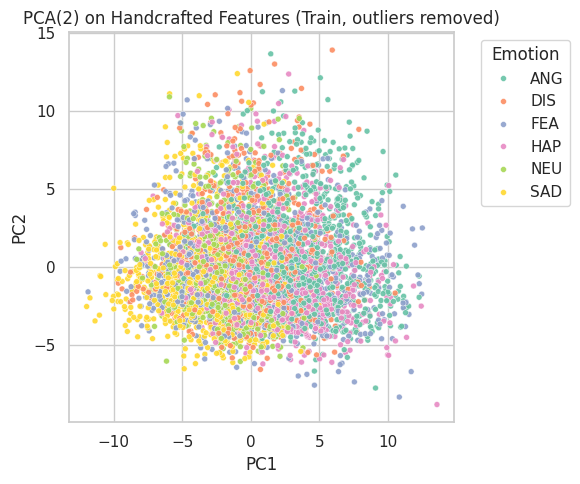

In [20]:
# 比如你确认就删这一条 / 或上一步列出的全部 outlier
bad_fnames = outlier_info   # 或例如 ["1076_MTI_SAD_XX.wav"]

print("Remove outliers:", bad_fnames)
feat_df_clean = feat_df.drop(index=bad_fnames)

# 后面 4.1 开始，用 feat_df_clean 替代 feat_df
le_emo = LabelEncoder()
y_all = le_emo.fit_transform(feat_df_clean["emotion"].values)

groups = meta.set_index("path").loc[
    feat_df_clean.index.map(lambda n: AUDIO_DIR/n), "speaker"
].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(feat_df_clean, y_all, groups=groups))

X_all = feat_df_clean.drop(
    columns=["emotion","speaker","intensity","duration_sec"]
).astype(np.float32).values

X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

pca_2 = PCA(n_components=2, random_state=SEED)
P_train = pca_2.fit_transform(X_train)

with plt.rc_context({
    'font.family': 'DejaVu Sans',
    'mathtext.default': 'regular',
    'text.usetex': False
}):
    plt.figure(figsize=(6,5))
    sns.scatterplot(
        x=P_train[:,0], y=P_train[:,1],
        hue=le_emo.inverse_transform(y_train),
        palette="Set2", s=18, alpha=0.9
    )
    plt.title("PCA(2) on Handcrafted Features (Train, outliers removed)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Emotion", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [21]:
# 0) Imports & Utilities
# =====================
import os, math, numpy as np, tensorflow as tf
from pathlib import Path
import librosa, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras import layers, models, callbacks

In [22]:
# 固定随机种子
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

# 你的 AudioWAV 路径 & 已有的 meta（含 path/emotion/intensity/speaker）
AUDIO_DIR = Path(AUDIO_DIR)  # 保持你之前的定义
assert AUDIO_DIR.exists()

# =====================
# 1) Log‑Mel 特征集（统一采样率/长度 + 训练集Z-Score）
# =====================
SR = 16000; N_MELS = 64; FFT = 1024; HOP = 160; WIN = 400
FIXED_SECONDS = 3.0
MAX_FRAMES = int(math.ceil(FIXED_SECONDS * SR / HOP))

INTEN_MAP = {"LO":0, "MD":1, "HI":2}  # XX 不训练

def load_logmel(path: Path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    tgt = int(FIXED_SECONDS * SR)
    if len(y) < tgt: y = np.pad(y, (0, tgt - len(y)))
    else: y = y[:tgt]
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=FFT, hop_length=HOP,
                                       win_length=WIN, n_mels=N_MELS, power=2.0)
    Sdb = librosa.power_to_db(S, ref=np.max).astype(np.float32)  # (mel, T)
    feat = np.transpose(Sdb[..., None], (1,0,2))                 # -> (T, mel, 1)
    if feat.shape[0] < MAX_FRAMES:
        feat = np.pad(feat, ((0, MAX_FRAMES-feat.shape[0]), (0,0), (0,0)))
    else:
        feat = feat[:MAX_FRAMES]
    return feat

# 批量构建
spec, emo_list, inten_list, spk_list = [], [], [], []
for r in meta.itertuples():
    spec.append(load_logmel(r.path))
    emo_list.append(r.emotion)
    inten_list.append(r.intensity)
    spk_list.append(r.speaker)
spec = np.stack(spec)  # (N, T, mel, 1)

# 标签编码 & 说话人独立划分
le_emo = LabelEncoder()
y_emo = le_emo.fit_transform(emo_list).astype(np.int32)
y_int = np.array([INTEN_MAP.get(s, -1) for s in inten_list], dtype=np.int32) # XX->-1
groups = np.array(spk_list)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
tr_idx, te_idx = next(gss.split(spec, y_emo, groups=groups))
Xtr, Xte = spec[tr_idx], spec[te_idx]
ytr_emo, yte_emo = y_emo[tr_idx], y_emo[te_idx]
ytr_int, yte_int = y_int[tr_idx], y_int[te_idx]

# 训练集Z-Score（逐通道）
mean_spec = Xtr.mean(axis=(0,1,2), keepdims=True)
std_spec  = Xtr.std(axis=(0,1,2), keepdims=True) + 1e-6
Xtr = (Xtr - mean_spec) / std_spec
Xte = (Xte - mean_spec) / std_spec

print("Train/Val shapes:", Xtr.shape, Xte.shape, " #classes:", len(le_emo.classes_))

Train/Val shapes: (5890, 300, 64, 1) (1552, 300, 64, 1)  #classes: 6


In [23]:
# =====================
# 2) 训练期增强层（SpecAugment + 轻噪声）
# =====================
class SpecAugment(layers.Layer):
    def __init__(self, tmask=2, fmask=2, tmax=24, fmax=8, **kw):
        super().__init__(**kw); self.tmask=tmask; self.fmask=fmask; self.tmax=tmax; self.fmax=fmax
    def call(self, x, training=False):
        if training:
            T = tf.shape(x)[1]; F = tf.shape(x)[2]
            for _ in range(self.tmask):
                t = tf.random.uniform([], 0, self.tmax, dtype=tf.int32)
                t0= tf.random.uniform([], 0, tf.maximum(1, T-t), dtype=tf.int32)
                x = x * tf.concat([tf.ones([t0,F,1]), tf.zeros([t,F,1]), tf.ones([T-t0-t,F,1])], axis=0)
            for _ in range(self.fmask):
                f = tf.random.uniform([], 0, self.fmax, dtype=tf.int32)
                f0= tf.random.uniform([], 0, tf.maximum(1, F-f), dtype=tf.int32)
                x = x * tf.concat([tf.ones([T,f0,1]), tf.zeros([T,f,1]), tf.ones([T,F-f0-f,1])], axis=1)
        return x

class AddGaussianNoise(layers.Layer):
    def __init__(self, std=0.02, **kw): super().__init__(**kw); self.std=std
    def call(self, x, training=False):
        return x + tf.random.normal(tf.shape(x), stddev=self.std) if training else x

def se_block(x, ratio=8):
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(ch//ratio, 4), activation="relu")(s)
    s = layers.Dense(ch, activation="sigmoid")(s)
    s = layers.Reshape((1,1,ch))(s)
    return layers.Multiply()([x, s])

In [24]:
# =====================
# 3) 三种模型构建器（CNN / CRNN / Transformer）
# =====================
def build_model(arch="cnn", input_shape=(MAX_FRAMES, N_MELS, 1), n_emo=6, n_int=3):
    inp = layers.Input(shape=input_shape)
    x = AddGaussianNoise(0.02)(inp)
    x = SpecAugment()(x)

    # 3.1 CNN 干端
    x = layers.Conv2D(32, (5,5), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPool2D((2,2))(x); x = se_block(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPool2D((2,2))(x); x = se_block(x)
    x = layers.Conv2D(128,(3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x); x = layers.SpatialDropout2D(0.2)(x); x = layers.MaxPool2D((2,2))(x)

    if arch == "cnn":
        h = layers.GlobalAveragePooling2D()(x)
        h = layers.Dense(128, activation="relu")(h); h = layers.Dropout(0.3)(h)

    elif arch == "crnn":
        # (B, T', F', C) -> (B, T', F'*C) -> BiLSTM
        Tprime = x.shape[1]
        h = layers.Reshape((Tprime, -1))(x)
        h = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(h)
        h = layers.Dropout(0.3)(h)

    elif arch == "transformer":
        # (B, T', F', C) -> (B, T', F'*C)
        Tprime = x.shape[1]
        h = layers.Reshape((Tprime, -1))(x)
        # 两层 TransformerEncoder
        def trans_block(z, heads=4, d=128, ff=256, rate=0.1):
            attn = layers.MultiHeadAttention(num_heads=heads, key_dim=d//heads)(z, z)
            z = layers.LayerNormalization()(z + attn)
            ff1 = layers.Dense(ff, activation="relu")(z)
            ff2 = layers.Dense(d)(ff1)
            z = layers.LayerNormalization()(z + ff2)
            z = layers.Dropout(rate)(z)
            return z
        # 对齐维度
        h = layers.Dense(128)(h)
        h = trans_block(h); h = trans_block(h)
        h = layers.GlobalAveragePooling1D()(h)
        h = layers.Dropout(0.3)(h)

    else:
        raise ValueError("arch must be 'cnn' | 'crnn' | 'transformer'")

    emo_out   = layers.Dense(n_emo, activation="softmax", name="emo_out")(h)
    inten_out = layers.Dense(n_int, activation="softmax", name="inten_out")(h)

    model = models.Model(inp, [emo_out, inten_out])
    # model.compile(
    #     optimizer=tf.keras.optimizers.Adam(1e-3),
    #     loss={"emo_out":"sparse_categorical_crossentropy", "inten_out":"sparse_categorical_crossentropy"},
    #     # loss_weights={"emo_out":1.0, "inten_out":0.3},
    #     metrics={"emo_out":["accuracy"], "inten_out":["accuracy"]}
    # )

    model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    # 两个输出，对应两个 loss，用“列表”按顺序对齐
    loss=[
        "sparse_categorical_crossentropy",  # 对应 emo_out
        "sparse_categorical_crossentropy",  # 对应 inten_out
    ],
    # 如果你还想让强度分支权重小一点，可以这样设
    loss_weights=[1.0, 0.3],               # 对应 [emo_out, inten_out]
    metrics=[
        ["accuracy"],                      # emo_out 的 metrics
        ["accuracy"],                      # inten_out 的 metrics
    ],
)


    return model

In [25]:
# =====================
# 4) 类别权重 & 样本权重（忽略XX强度）
# =====================
# 情绪 class_weight（按训练分布）

# 4.1 情绪 class_weight -> emo_sw（每个样本一个权重）
u, c = np.unique(ytr_emo, return_counts=True)
median_c = np.median(c)
class_weight_emo = {int(k): float(median_c / v) for k, v in zip(u, c)}
print("emotion class_weight:", class_weight_emo)

# 展开成每个样本的权重
emo_sw = np.array([class_weight_emo[int(lbl)] for lbl in ytr_emo], dtype=np.float32)

# 4.2 强度 sample_weight（只在 LO/MD/HI 上给权重；XX=-1 -> 0）
u_i, c_i = np.unique(ytr_int[ytr_int >= 0], return_counts=True)
med_i = np.median(c_i)
cls_w_int = {int(k): float(med_i / v) for k, v in zip(u_i, c_i)}
print("intensity class_weight (for known):", cls_w_int)

inten_sw = np.zeros_like(ytr_int, dtype=np.float32)
for i, lab in enumerate(ytr_int):
    inten_sw[i] = cls_w_int.get(int(lab), 0.0)  # LO/MD/HI -> 权重；XX=-1 -> 0.0

print("emo_sw shape:", emo_sw.shape, "inten_sw shape:", inten_sw.shape)

emotion class_weight: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.169767441860465, 5: 1.0}
intensity class_weight (for known): {0: 1.0, 1: 1.0, 2: 1.0}
emo_sw shape: (5890,) inten_sw shape: (5890,)


In [31]:
# =====================
# 5) 训练：宏F1回调 + 早停 + 学习率调度
# =====================
class ValMacroF1(callbacks.Callback):
    def __init__(self, Xv, yv): super().__init__(); self.Xv=Xv; self.yv=yv
    def on_epoch_end(self, epoch, logs=None):
        yp = np.argmax(self.model.predict(self.Xv, verbose=0)[0], axis=1)
        f1 = f1_score(self.yv, yp, average="macro")
        logs = logs or {}; logs["val_macro_f1"] = f1
        print(f" — val_macro_f1: {f1:.4f}")

def train_one(arch="cnn", epochs=60, batch=32):
    tf.keras.backend.clear_session()
    model = build_model(arch=arch, input_shape=Xtr.shape[1:], n_emo=len(le_emo.classes_), n_int=3)
    # 修改后：
    ckpt = callbacks.ModelCheckpoint(f"best_{arch}.h5", monitor="val_macro_f1", 
                                 mode="max", save_best_only=True, verbose=1)
    early = callbacks.EarlyStopping(monitor="val_macro_f1", mode="max", patience=10, restore_best_weights=True)
    plateau = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1)

    # hist = model.fit(
    #     Xtr,
    #     {"emo_out": ytr_emo, "inten_out": np.clip(ytr_int, 0, 2)},
    #     validation_data=(Xte, {"emo_out": yte_emo, "inten_out": np.clip(yte_int, 0, 2)}),
    #     epochs=epochs, batch_size=batch,
    #     # class_weight={"emo_out": class_weight_emo},        # 只给情绪分支类权重
    #     # sample_weight={"inten_out": inten_sw},             # 强度分支样本权重（XX=0）
    #     sample_weight={
    #         "emo_out": emo_sw,
    #         "inten_out": inten_sw
    #     },
    #     callbacks=[ValMacroF1(Xte, yte_emo), ckpt, early, plateau],
    #     verbose=1
    # )

    # 注意：这里 y → 列表； sample_weight → 列表
    hist = model.fit(
        Xtr,
        [
            ytr_emo,                       # 第一个输出 emo_out
            np.clip(ytr_int, 0, 2),       # 第二个输出 inten_out
        ],
        validation_data=(
            Xte,
            [
                yte_emo,
                np.clip(yte_int, 0, 2),
            ],
        ),
        epochs=epochs,
        batch_size=batch,
        sample_weight=[
            emo_sw,                        # 对应 emo_out
            inten_sw,                      # 对应 inten_out
        ],
        callbacks=[ValMacroF1(Xte, yte_emo), ckpt, early, plateau],
        verbose=1,
    )
    return model, hist

In [32]:
# 先构建一次模型（不训练）
tmp_model = build_model(
    arch="cnn",
    input_shape=Xtr.shape[1:],
    n_emo=len(le_emo.classes_),
    n_int=3
)

print(tmp_model.output_names)
tmp_model.summary()

['emo_out', 'inten_out']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 64, 1)]         0         []                            
                                                                                                  
 add_gaussian_noise_1 (AddG  (None, 300, 64, 1)           0         ['input_2[0][0]']             
 aussianNoise)                                                                                    
                                                                                                  
 spec_augment_1 (SpecAugmen  (None, 300, 64, 1)           0         ['add_gaussian_noise_1[0][0]']
 t)                                                                                               
                                                                   

In [33]:
print(type(emo_sw), emo_sw.dtype, emo_sw.shape)
print(type(inten_sw), inten_sw.dtype, inten_sw.shape)


<class 'numpy.ndarray'> float32 (5890,)
<class 'numpy.ndarray'> float32 (5890,)


In [35]:
# =====================
# 6) 运行：任选其一，或都试（cnn / crnn / transformer）
# =====================
ARCH = "cnn"           # "cnn" | "crnn" | "transformer"
model, hist = train_one(arch=ARCH, epochs=50, batch=128)

Epoch 1/50


2025-11-27 05:40:25.378047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/47 [============================>.] - ETA: 0s - loss: 1.6831 - emo_out_loss: 1.6207 - inten_out_loss: 0.2079 - emo_out_accuracy: 0.3341 - inten_out_accuracy: 0.3488 — val_macro_f1: 0.0626

Epoch 1: val_macro_f1 improved from -inf to 0.06263, saving model to best_cnn.h5
47/47 [==============================] - 9s 84ms/step - loss: 1.6830 - emo_out_loss: 1.6206 - inten_out_loss: 0.2078 - emo_out_accuracy: 0.3341 - inten_out_accuracy: 0.3487 - val_loss: 2.1549 - val_emo_out_loss: 1.8125 - val_inten_out_loss: 1.1411 - val_emo_out_accuracy: 0.1695 - val_inten_out_accuracy: 0.0612 - val_macro_f1: 0.0626 - lr: 0.0010
Epoch 2/50
46/47 [============================>.] - ETA: 0s - loss: 1.5714 - emo_out_loss: 1.5131 - inten_out_loss: 0.1943 - emo_out_accuracy: 0.3884 - inten_out_accuracy: 0.3351 — val_macro_f1: 0.0486

Epoch 2: val_macro_f1 did not improve from 0.06263
47/47 [==============================] - 3s 67ms/step - loss: 1.5714 - emo_out_loss: 1.5130 - inten_out_loss: 0.1946 - emo_ou

              precision    recall  f1-score   support

         ANG     0.6897    0.6792    0.6844       265
         DIS     0.4828    0.2642    0.3415       265
         FEA     0.5888    0.2377    0.3387       265
         HAP     0.4475    0.4981    0.4714       265
         NEU     0.4246    0.6696    0.5197       227
         SAD     0.4663    0.6792    0.5530       265

    accuracy                         0.5006      1552
   macro avg     0.5166    0.5047    0.4848      1552
weighted avg     0.5188    0.5006    0.4839      1552



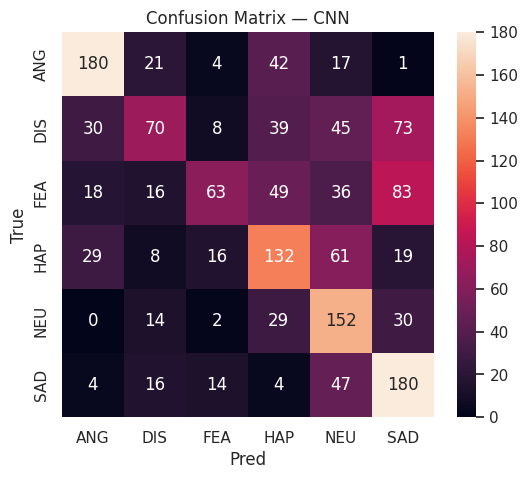

In [36]:
# =====================
# 7) 评估
# =====================
emo_pred, inten_pred = model.predict(Xte, verbose=0)
yhat = np.argmax(emo_pred, axis=1)
print(classification_report(yte_emo, yhat, target_names=le_emo.classes_, digits=4))
cm = confusion_matrix(yte_emo, yhat)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=le_emo.classes_, yticklabels=le_emo.classes_)
plt.title(f"Confusion Matrix — {ARCH.upper()}"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

In [37]:
# =====================
# 6) 运行：任选其一，或都试（cnn / crnn / transformer）
# =====================
ARCH = "crnn"           # "cnn" | "crnn" | "transformer"
model, hist = train_one(arch=ARCH, epochs=50, batch=128)

Epoch 1/50


2025-11-27 05:43:28.341646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/47 [============================>.] - ETA: 0s - loss: 1.6864 - emo_out_loss: 1.6229 - inten_out_loss: 0.2116 - emo_out_accuracy: 0.3417 - inten_out_accuracy: 0.3101 — val_macro_f1: 0.1125

Epoch 1: val_macro_f1 improved from -inf to 0.11250, saving model to best_crnn.h5
47/47 [==============================] - 13s 122ms/step - loss: 1.6864 - emo_out_loss: 1.6229 - inten_out_loss: 0.2116 - emo_out_accuracy: 0.3418 - inten_out_accuracy: 0.3100 - val_loss: 2.1606 - val_emo_out_loss: 1.8774 - val_inten_out_loss: 0.9440 - val_emo_out_accuracy: 0.2023 - val_inten_out_accuracy: 0.6488 - val_macro_f1: 0.1125 - lr: 0.0010
Epoch 2/50
46/47 [============================>.] - ETA: 0s - loss: 1.5837 - emo_out_loss: 1.5270 - inten_out_loss: 0.1890 - emo_out_accuracy: 0.3872 - inten_out_accuracy: 0.4164 — val_macro_f1: 0.1222

Epoch 2: val_macro_f1 improved from 0.11250 to 0.12221, saving model to best_crnn.h5
47/47 [==============================] - 4s 79ms/step - loss: 1.5835 - emo_out_loss: 1.5

              precision    recall  f1-score   support

         ANG     0.6203    0.8075    0.7016       265
         DIS     0.4917    0.3358    0.3991       265
         FEA     0.5417    0.3925    0.4551       265
         HAP     0.4255    0.4528    0.4388       265
         NEU     0.5506    0.6476    0.5951       227
         SAD     0.4982    0.5358    0.5164       265

    accuracy                         0.5258      1552
   macro avg     0.5213    0.5287    0.5177      1552
weighted avg     0.5206    0.5258    0.5158      1552



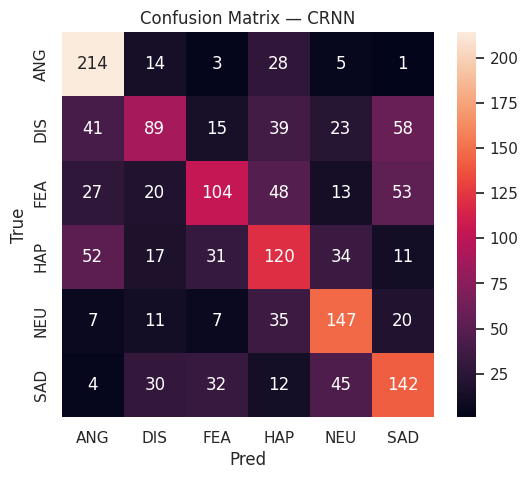

In [38]:
# =====================
# 7) 评估
# =====================
emo_pred, inten_pred = model.predict(Xte, verbose=0)
yhat = np.argmax(emo_pred, axis=1)
print(classification_report(yte_emo, yhat, target_names=le_emo.classes_, digits=4))
cm = confusion_matrix(yte_emo, yhat)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=le_emo.classes_, yticklabels=le_emo.classes_)
plt.title(f"Confusion Matrix — {ARCH.upper()}"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

In [ ]:
# =====================
# 6) 运行：任选其一，或都试（cnn / crnn / transformer）
# =====================
ARCH = "transformer"           # "cnn" | "crnn" | "transformer"
model, hist = train_one(arch=ARCH, epochs=50, batch=128)

Epoch 1/100


2025-11-27 05:52:53.329206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


46/47 [============================>.] - ETA: 0s - loss: 1.8697 - emo_out_loss: 1.8033 - inten_out_loss: 0.2211 - emo_out_accuracy: 0.3130 - inten_out_accuracy: 0.3533 — val_macro_f1: 0.0486

Epoch 1: val_macro_f1 improved from -inf to 0.04861, saving model to best_transformer.h5
47/47 [==============================] - 16s 112ms/step - loss: 1.8700 - emo_out_loss: 1.8037 - inten_out_loss: 0.2210 - emo_out_accuracy: 0.3131 - inten_out_accuracy: 0.3531 - val_loss: 3.4090 - val_emo_out_loss: 3.2266 - val_inten_out_loss: 0.6081 - val_emo_out_accuracy: 0.1707 - val_inten_out_accuracy: 0.8776 - val_macro_f1: 0.0486 - lr: 0.0010
Epoch 2/100
46/47 [============================>.] - ETA: 0s - loss: 1.6453 - emo_out_loss: 1.5836 - inten_out_loss: 0.2055 - emo_out_accuracy: 0.3743 - inten_out_accuracy: 0.2818 — val_macro_f1: 0.0891

Epoch 2: val_macro_f1 improved from 0.04861 to 0.08908, saving model to best_transformer.h5
47/47 [==============================] - 4s 82ms/step - loss: 1.6452 - em

              precision    recall  f1-score   support

         ANG     0.6803    0.7547    0.7156       265
         DIS     0.4868    0.5585    0.5202       265
         FEA     0.6150    0.4340    0.5088       265
         HAP     0.5171    0.4566    0.4850       265
         NEU     0.5658    0.7004    0.6260       227
         SAD     0.5754    0.5472    0.5609       265

    accuracy                         0.5722      1552
   macro avg     0.5734    0.5752    0.5694      1552
weighted avg     0.5736    0.5722    0.5680      1552



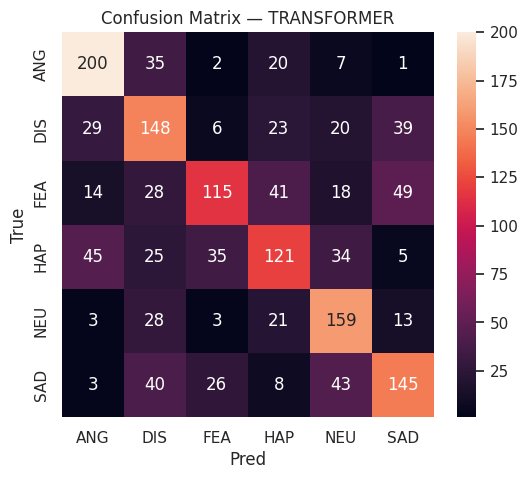

In [ ]:
# =====================
# 7) 评估
# =====================
emo_pred, inten_pred = model.predict(Xte, verbose=0)
yhat = np.argmax(emo_pred, axis=1)
print(classification_report(yte_emo, yhat, target_names=le_emo.classes_, digits=4))
cm = confusion_matrix(yte_emo, yhat)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=le_emo.classes_, yticklabels=le_emo.classes_)
plt.title(f"Confusion Matrix — {ARCH.upper()}"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()